In [64]:
import numpy as np
import pandas as pd
import osmnx as ox
import geopandas as gpd
from shapely.geometry import MultiPolygon

In [55]:
auckland_path = "data/geographic/territorial/public_transportauckland_territory.gpkg"

In [56]:
auckland = gpd.read_file(auckland_path)
polygon = auckland.iloc[0]['geometry']
#df = gpd.GeoDataFrame({'id':[1],'geometry':[geo_shape]})

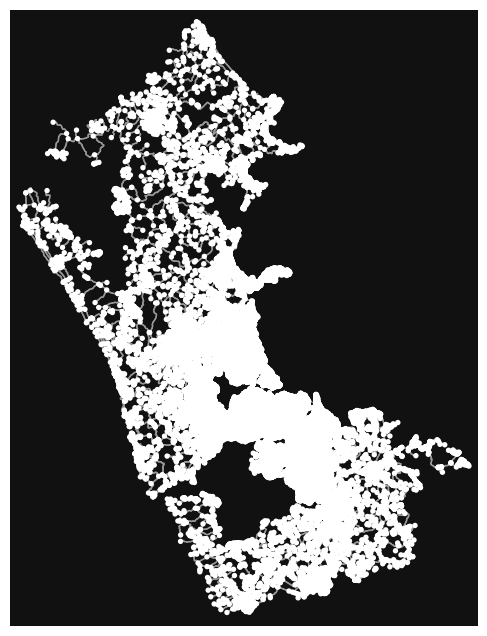

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [58]:
G = ox.graph_from_polygon(polygon, network_type="walk")
ox.plot_graph(G)

In [62]:
ox.simplification.consolidate_intersections(G, rebuild_graph=True)

/opt/miniconda3/envs/ox/lib/python3.10/site-packages/osmnx/simplification.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged = utils_graph.graph_to_gdfs(G, edges=False)["geometry"].buffer(tolerance).unary_union
/opt/miniconda3/envs/ox/lib/python3.10/site-packages/osmnx/simplification.py:474: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = node_clusters.centroid


In [63]:
ox.io.save_graph_geopackage(G, filepath="auckland_network_walk_consolidated", encoding='utf-8', directed=False)

/opt/miniconda3/envs/ox/lib/python3.10/site-packages/osmnx/simplification.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged = utils_graph.graph_to_gdfs(G, edges=False)["geometry"].buffer(tolerance).unary_union
/opt/miniconda3/envs/ox/lib/python3.10/site-packages/osmnx/simplification.py:474: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = node_clusters.centroid


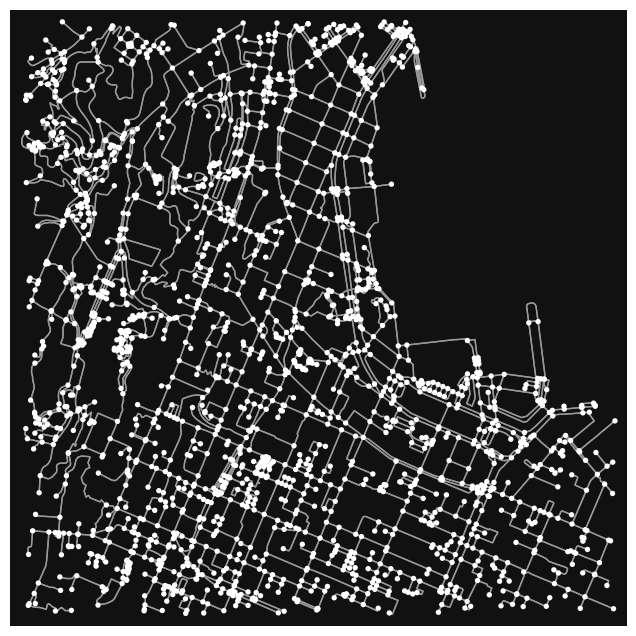

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [68]:
well = ox.graph_from_address("Wellington, New Zealand", dist=1000, network_type="walk")
ox.simplification.consolidate_intersections(well, rebuild_graph=True)
ox.plot_graph(well)

<AxesSubplot: >

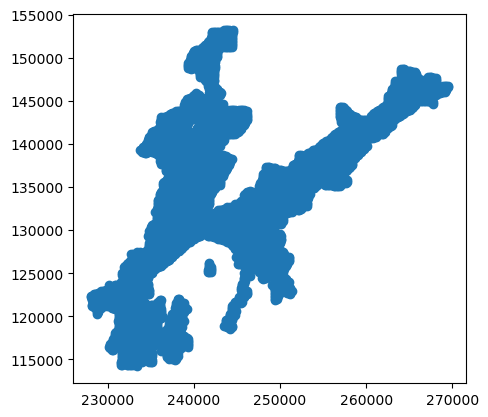

In [75]:
grid = gpd.read_file("data/geographic/grids/grid_10000_welly.gpkg")
grid2 = grid.iloc[0]['geometry']
grid.plot()